# Statistical Analysis on Scoring Bias: 2024 Argentine Tango World Championship
In this project we will use PyMC to analyze the biases present in scoring dance competitors in the world's largest and most recognized Argentine Tango competition held in Buenos Aires, Argentine every year.

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt

### Load and prepare the raw data

In [174]:
# Load the raw data
scores = (pd.read_csv('../data/raw/Ranking-Clasificatoria-Tango-de-Pista-Mundial-de-tango-2024.csv')
          .drop('Unnamed: 0', axis=1)
          .rename(columns=
                  {
                      'PAREJA': 'couple',
                      'Nombre y Apellido': 'male_contestant',
                      'Nombre y Apellido.1': 'female_contestant',
                      'PROMEDIO': 'avg_score'
                  })
          .set_index(['couple','male_contestant','female_contestant'])
          .apply(pd.to_numeric, errors='coerce')
          .dropna(subset='avg_score')
          .reset_index(drop=False)
          .assign(couple = lambda x: x['couple'].astype(int),
                  male_contestant = lambda x: x['male_contestant'].astype('string'),
                  female_contestant = lambda x: x['female_contestant'].astype('string'),
                  )
)
scores['panel'] = scores.apply(lambda x: 'Panel 2' if np.isnan(x.iloc[[3, 4, 5, 6, 7, 13, 14, 15, 16, 17]].mean()) else 'Panel 1', axis=1).astype('string')
scores.columns = scores.columns.str.replace('\n', ' ')
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   couple               516 non-null    int32  
 1   male_contestant      516 non-null    string 
 2   female_contestant    516 non-null    string 
 3   Jimena Hoffner       290 non-null    float64
 4   Silvina Valz         296 non-null    float64
 5   Gaston Torelli       296 non-null    float64
 6   Martin Ojeda         296 non-null    float64
 7   Laura Melo           296 non-null    float64
 8   Graciela Gonzalez    221 non-null    float64
 9   Aoniken Quiroga      221 non-null    float64
 10  Paola Tachetti       221 non-null    float64
 11  Facundo de la Cruz   221 non-null    float64
 12  Stella Baez          221 non-null    float64
 13  Agustin Agnez        295 non-null    float64
 14  Magdalena Gutierrez  295 non-null    float64
 15  Lucas Paez           295 non-null    flo

In [176]:
# Create a long format dataframe with scores as integers for training the probit model
ordinal_scores = (scores.drop(columns=['avg_score', 'panel'])
                  .melt(id_vars=['couple', 'male_contestant', 'female_contestant'], var_name='judge', value_name='score', ignore_index=False)
                  .dropna(subset='score')
                  .reset_index(drop=True)
                  .assign(couple = lambda x: x['couple'].astype(int))                  
)
ordinal_scores['ordinal_score_4'] = pd.cut(ordinal_scores['score'], bins=np.arange(5, 9.1, 1), right=False, labels=range(4))
ordinal_scores['ordinal_score_7'] = pd.cut(ordinal_scores['score'], bins=np.arange(5, 8.6, 0.5), right=False, labels=range(7))
ordinal_scores.head()


,couple,male_contestant,female_contestant,judge,score,ordinal_score_4,ordinal_score_7
0,424,Lucas Gauto,Naima Gerasopoulou,Jimena Hoffner,8.0,3,6
1,585,Juan David Vargas,Ornella Simonetto,Jimena Hoffner,7.6,2,5
2,477,Diego Ortega,Aldana Silveyra,Jimena Hoffner,7.5,2,5
3,127,Leandro Capparelli,Jeannette Erazú,Jimena Hoffner,7.5,2,5
4,60,Ariel Manzanares,Aldana Belen Figueroa,Jimena Hoffner,7.4,2,4


In [43]:
ordinal_categories_4 = ordinal_scores['ordinal_score_4'].sort_values().unique()
ordinal_categories_7 = ordinal_scores['ordinal_score_7'].sort_values().unique()
print(ordinal_categories_4)
print(ordinal_categories_7)

[0, 1, 2, 3]
Categories (4, int64): [0 < 1 < 2 < 3]
[0, 1, 2, 3, 4, 5, 6]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]


### Define a probabilistic model in PyMC

In [44]:
# Define a convenience function to specify a prior over the cutpoints in the latent space
# The Dirichlet distribution is special in that draws from the distribution must sum to one. 
# This function ensures that each draw from the prior distribution is a cumulative share of the maximum category greater than the minimum of our ordinal categorisation.
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min) + min, # type: ignore
            ]
        ),
    )

def make_probit_model(ordinal_scores, priors, dims, dim_idx, categories):
    with pm.Model(coords=dims) as model:
        obs = pm.Data('observed_scores', ordinal_scores, dims='obs_id')
        couple_id = pm.Data('couple_id', dim_idx['couple_idx'], dims='obs_id')   
        judge_id = pm.Data('judge_id', dim_idx['judge_idx'], dims='obs_id')

        # Latent ability of each couple
        omega_couples = pm.Normal('omega_couples', mu=priors['omega_couples'][0], sigma=priors['omega_couples'][1]) # Mean of population of all couples
        tau_couples = pm.HalfNormal('tau_couples', sigma=priors['tau_couples'][0]) # Between couple variability
        z_couple = pm.Normal('z_culture', mu=0.0, sigma=1.0, dims='couple')
        mu_couple = pm.Deterministic('mu_couple', omega_couples + z_couple*tau_couples, dims='couple')

        # Panel traits
        panel_sensitivity = pm.Normal('panel_sensitivity', mu=priors['panel_sensitivity'][0], sigma=priors['panel_sensitivity'][1]) # Global mean sensitivity of all judges
        tau_sensitivity = pm.HalfNormal('tau_sensitivity', sigma=priors['tau_sensitivity'][0]) # Between judge variability in sensitivity
        
        panel_bias = pm.Normal('panel_bias', mu = priors['panel_bias'][0], sigma = priors['panel_bias'][1]) # Global mean bias of all judges
        tau_bias = pm.HalfNormal('tau_bias', sigma = priors['tau_bias'][0]) # Between judge variability in bias

        sigma_panel = pm.HalfNormal('sigma_panel', sigma=priors['sigma_panel'][0]) # Global variability of all judges
        tau_panel_log = pm.HalfNormal('tau_panel_log', sigma=priors['tau_panel_log'][0]) # Between judge variability in log-space

        # Traits of the individual judges
        z_sensitivity = pm.Normal('z_sensitivity', mu=0.0, sigma=1.0, dims='judge')
        judge_sensitivity = pm.Deterministic('judge_sensitivity', panel_sensitivity + z_sensitivity*tau_sensitivity, dims='judge') # Sensitivity of each judge

        z_bias = pm.Normal('z_bias', mu = 0.0, sigma = 1.0, dims = 'judge')
        judge_bias = pm.Deterministic('judge_bias', panel_bias + z_bias*tau_bias, dims='judge') # Bias of each judge
        
        z_judge = pm.Normal('z_panelist', mu=0.0, sigma=1.0, dims='judge')
        sigma_judge = pm.Deterministic('sigma_judge', pt.exp(pt.log(sigma_panel) + z_judge*tau_panel_log), dims='judge') # Variance of each judge

        # Define cutpoints
        n_categories = len(categories)
        min_category = min(categories)
        max_category = max(categories)        
        cutpoints = constrainedUniform(n_categories, min_category, max_category)

        # Define the likelihood
        couple_rating = pm.Deterministic('rating', mu_couple[couple_id]*judge_sensitivity[judge_id] + judge_bias[judge_id], dims='obs_id')
        pm.OrderedProbit('ordinal_score', cutpoints=cutpoints, eta=couple_rating, sigma = sigma_judge[judge_id], observed=obs, dims='obs_id')        

        return model
        

### Define priors and dimensions

In [45]:
# Define the priors
priors = {
            'omega_couples': [0.0, 3.0],
            'tau_couples': [1.0],                   
            'sigma_panel': [1.0],            
            'tau_panel_log': [0.3],
            'panel_sensitivity': [1.0, 0.2],   
            'tau_sensitivity': [1.0],        
            'panel_bias': [0.0, 0.5],
            'tau_bias': [1.0]            
        }

# Define the dimensions and indices
couple_idx, couples = ordinal_scores['couple'].factorize(sort=True)
judge_idx, judges = ordinal_scores['judge'].factorize(sort=True)

dims = dict(
    couple = couples,
    judge = judges
)

dim_idx = dict(
    couple_idx = couple_idx,
    judge_idx = judge_idx
)


## Make a model with seven ordinal categories

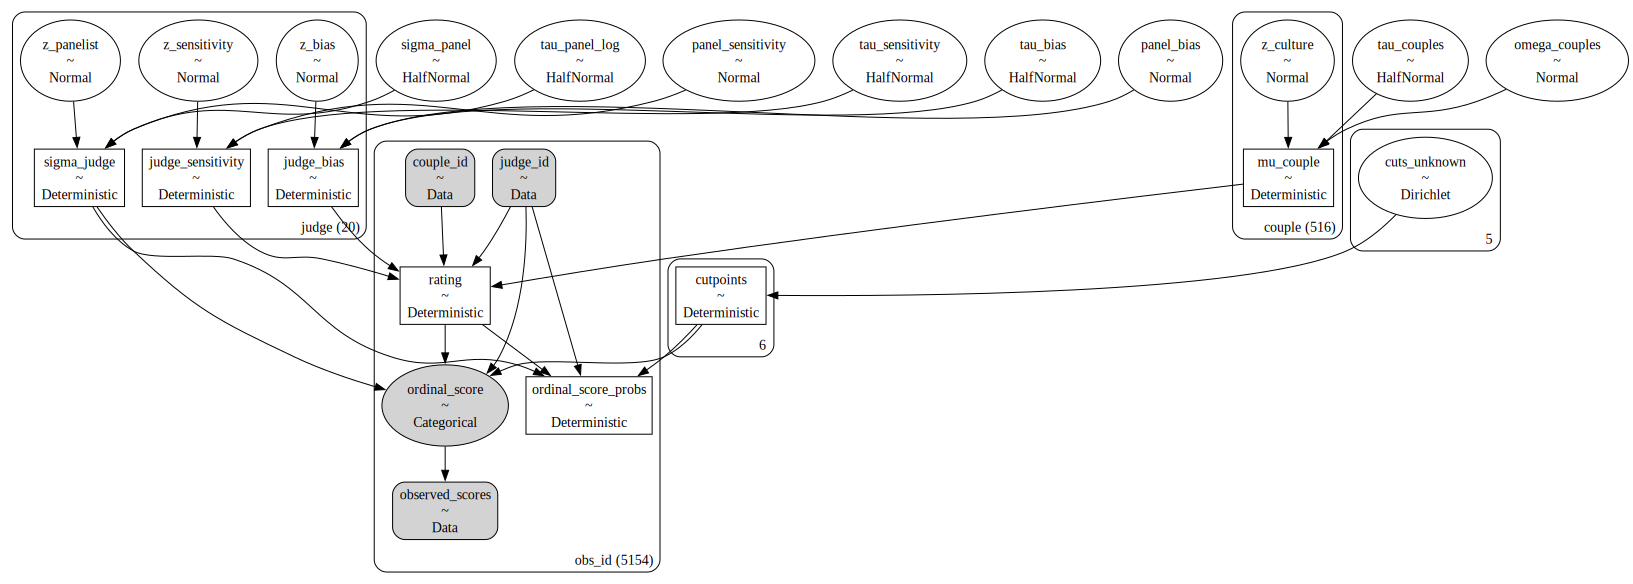

In [51]:
model_7_categories = make_probit_model(ordinal_scores['ordinal_score_7'], priors, dims, dim_idx, ordinal_categories_7)
pm.model_to_graphviz(model_7_categories)

### Prior predicitve checks

In [52]:
with model_7_categories:
    idata_7 = pm.sample_prior_predictive(samples=1000)

Sampling: [cuts_unknown, omega_couples, ordinal_score, panel_bias, panel_sensitivity, sigma_panel, tau_bias, tau_couples, tau_panel_log, tau_sensitivity, z_bias, z_culture, z_panelist, z_sensitivity]


<Axes: xlabel='ordinal_score'>

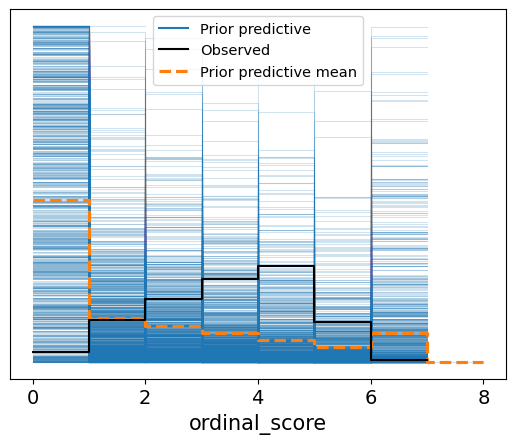

In [53]:
az.plot_ppc(idata_7, group='prior', observed=True, data_pairs={'observed_scores':'ordinal_score'})

### Fit model to data

In [54]:
# Run MCMC sampling
with model_7_categories:
    idata_7.extend(pm.sample(cores=10, chains=4))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [omega_couples, tau_couples, z_culture, panel_sensitivity, tau_sensitivity, panel_bias, tau_bias, sigma_panel, tau_panel_log, z_sensitivity, z_bias, z_panelist, cuts_unknown]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8214 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [55]:
# Save the data object
idata_7.to_netcdf('../data/intermediate/idata_7_categories.nc')

'../data/intermediate/idata_7_categories.nc'

### Plot the traces

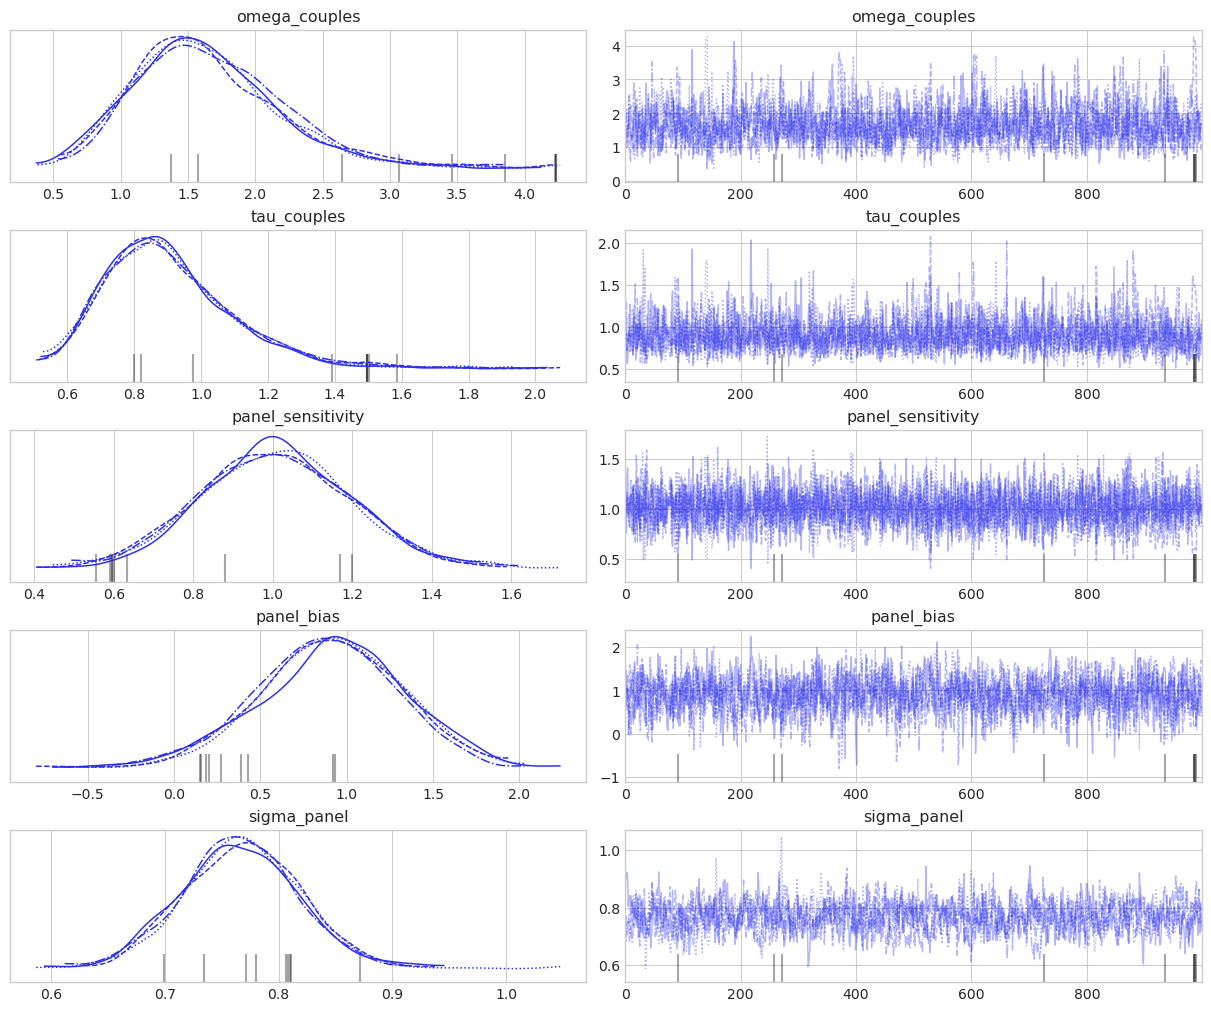

In [56]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    az.plot_trace(idata_7, var_names=['omega_couples','tau_couples','panel_sensitivity','panel_bias', 'sigma_panel'])

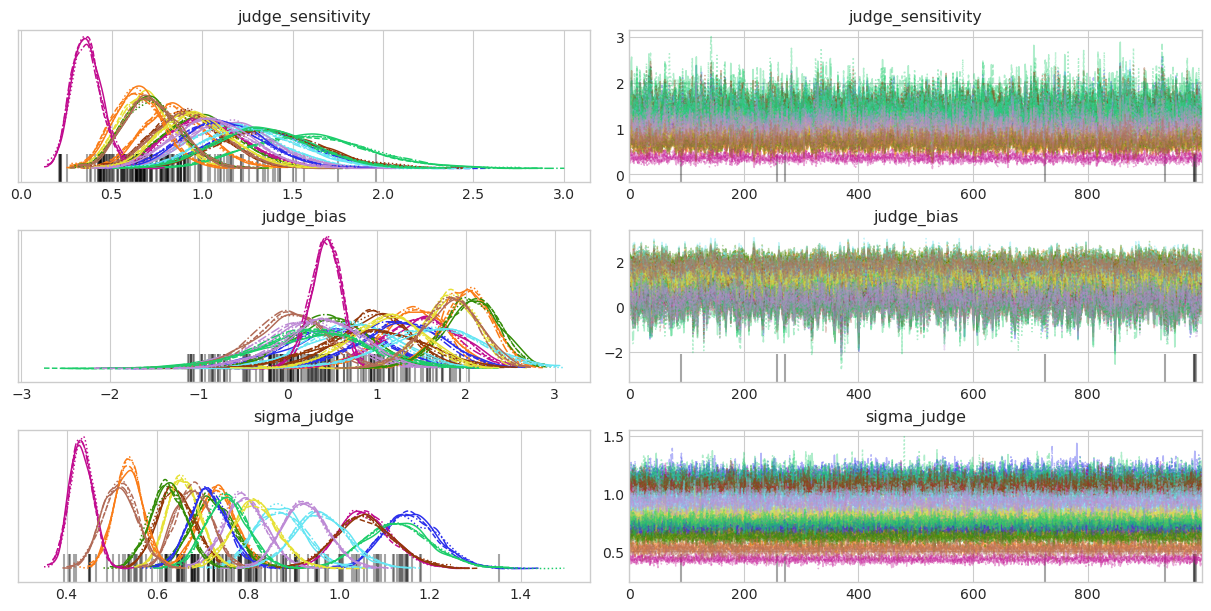

In [57]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    az.plot_trace(idata_7, var_names=['judge_sensitivity','judge_bias', 'sigma_judge'])

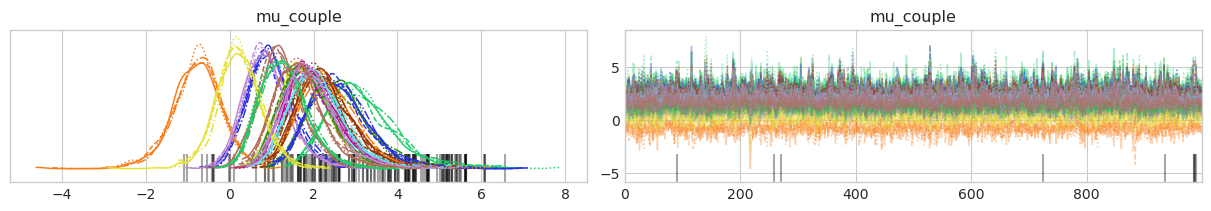

In [61]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    az.plot_trace(idata_7, var_names=['mu_couple'], coords={'couple':couples[:20]})

### Plot model variables

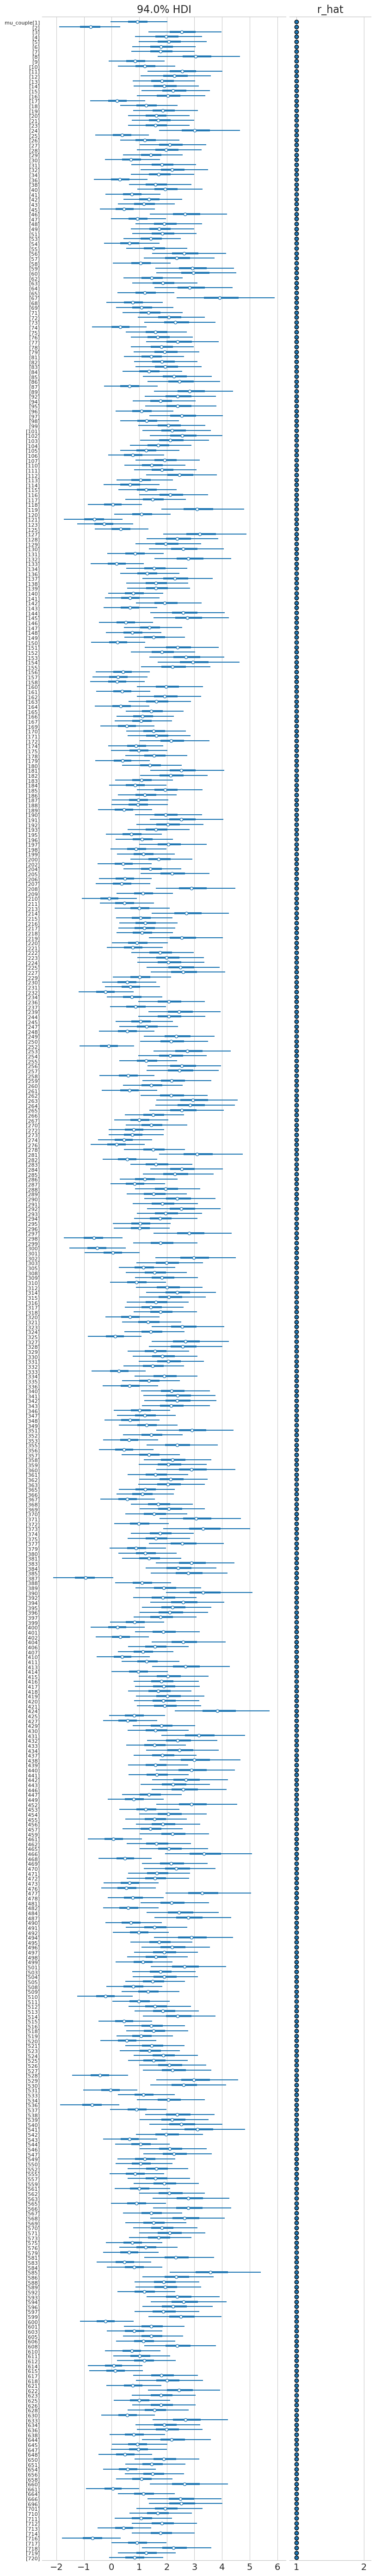

In [64]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    ax = az.plot_forest(idata_7, var_names='mu_couple', combined=True, r_hat=True)
    ax[0].tick_params(axis='y', which='major', labelsize=8)

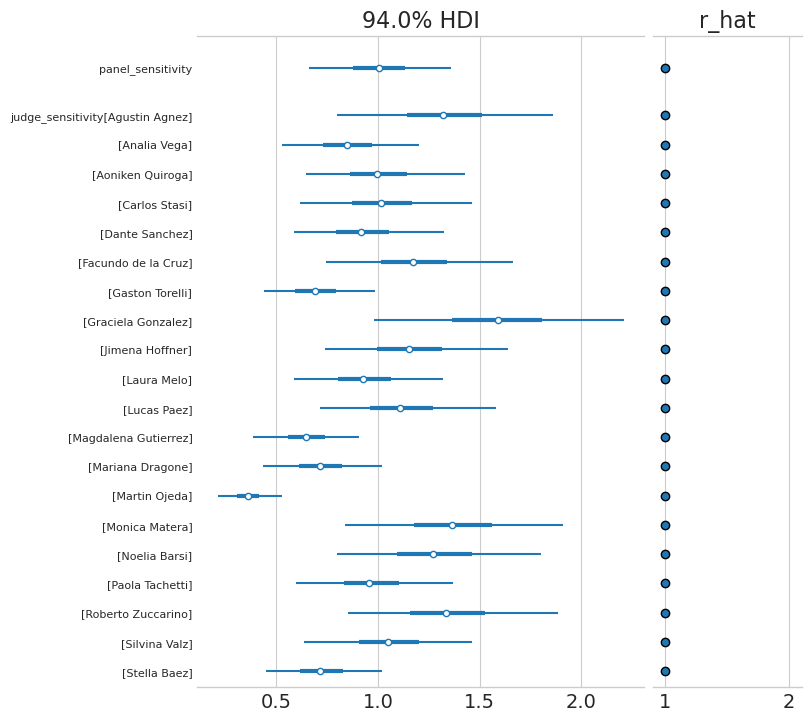

In [65]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    ax = az.plot_forest(idata_7, var_names=['panel_sensitivity', 'judge_sensitivity'], combined=True, r_hat=True)
    ax[0].tick_params(axis='y', which='major', labelsize=8)

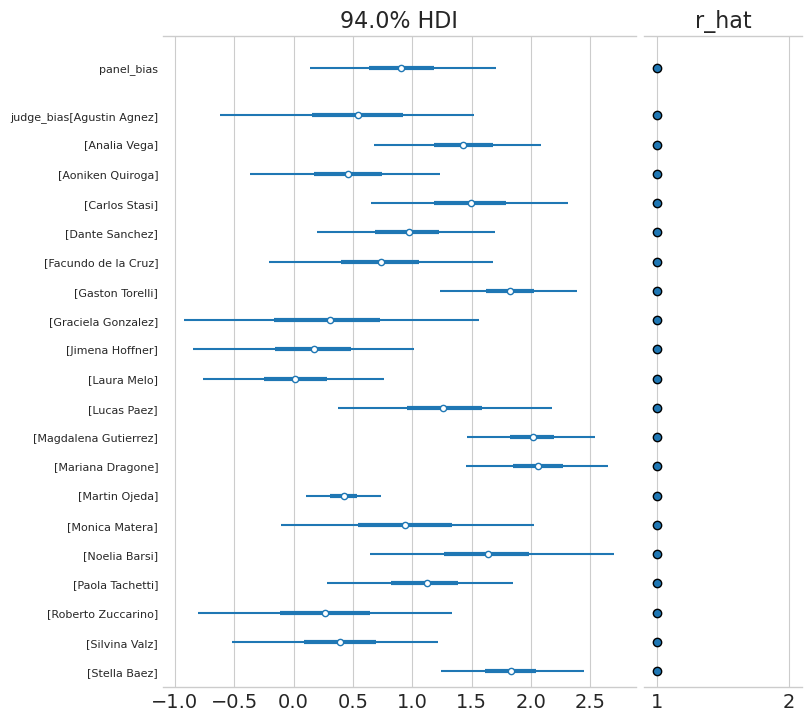

In [66]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):  
    ax = az.plot_forest(idata_7, var_names=['panel_bias', 'judge_bias'], combined=True, r_hat=True)
    ax[0].tick_params(axis='y', which='major', labelsize=8)

## Generate posterior predictions

In [67]:
with model_7_categories:
    pm.sample_posterior_predictive(idata_7, extend_inferencedata=True)

Sampling: [ordinal_score]


Output()

In [68]:
# Save the data object
idata_7.to_netcdf('../data/intermediate/idata_7_categories.nc')

'../data/intermediate/idata_7_categories.nc'

## Posterior checks

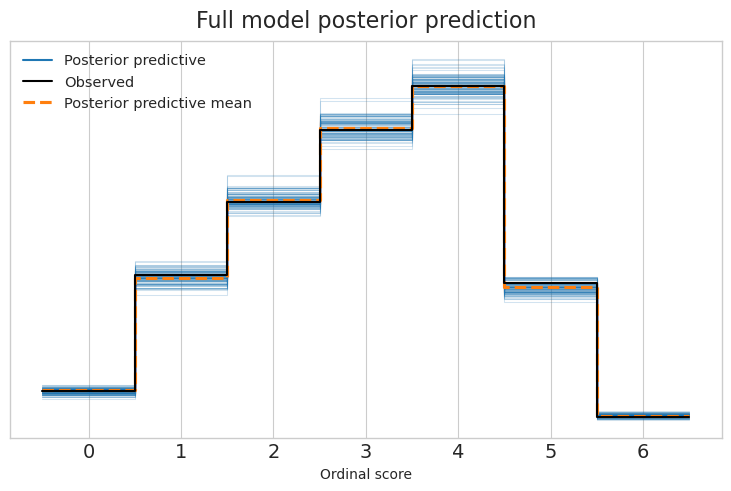

In [69]:
# Posterior distribution of the data
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):    
    fig, ax = plt.subplots(1,1)       
    az.plot_ppc(idata_7, num_pp_samples=100, ax=ax)
    fig.suptitle('Full model posterior prediction', fontsize=16)
    ax.set_xlabel('Ordinal score', fontsize=10)
    ax.set_xticks(0.5+np.arange(7))
    ax.set_xticklabels(range(7))      

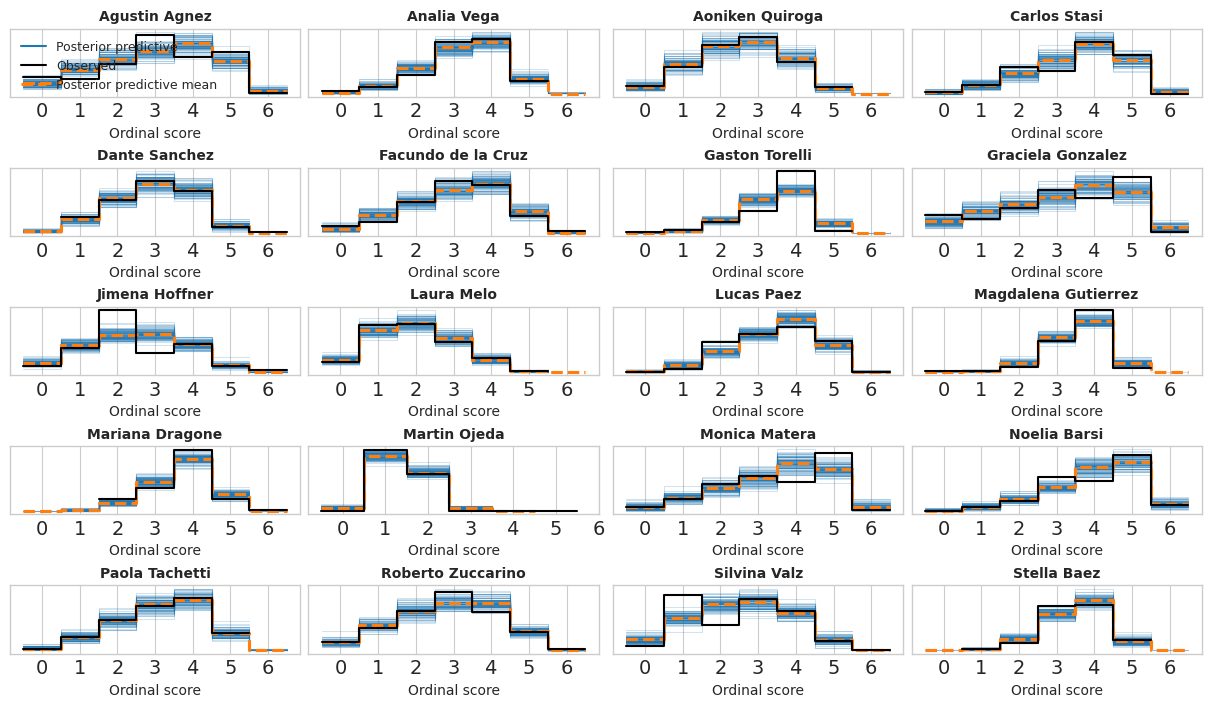

In [70]:
# Posterior distribution of the data grouped by each judge
style = 'arviz-whitegrid'
obs_judge = idata_7.posterior['judge'][judge_idx]
data_judge = idata_7.assign_coords(obs_id=obs_judge, groups='observed_vars')

with az.style.context(style, after_reset=True):    
    fig, axs = plt.subplots(5, 4, figsize=(12, 8*0.87), sharex=False)
    axs = axs.flatten()

    for i, judge in enumerate(judges):        
            az.plot_ppc(data_judge, coords={'obs_id': [judge]}, num_pp_samples=100, ax=axs[i])
            axs[i].legend(fontsize=9, loc='upper left')
            if i > 0:
                axs[i].get_legend().remove()
            axs[i].set_title(judge, fontsize=10, fontweight='bold')
            axs[i].set_xlabel('Ordinal score', fontsize=10)
            axs[i].set_xticks(0.5+np.arange(7))
            axs[i].set_xticklabels(range(7))            

## Inference results

### Is there a difference in the bias between Panel 1 and Panel 2?

Panel 1 judges: ['Jimena Hoffner', 'Silvina Valz', 'Gaston Torelli', 'Martin Ojeda', 'Laura Melo', 'Agustin Agnez', 'Magdalena Gutierrez', 'Lucas Paez', 'Roberto Zuccarino', 'Analia Vega']
Panel 2 judges: ['Aoniken Quiroga', 'Carlos Stasi', 'Dante Sanchez', 'Facundo de la Cruz', 'Graciela Gonzalez', 'Mariana Dragone', 'Monica Matera', 'Noelia Barsi', 'Paola Tachetti', 'Stella Baez']


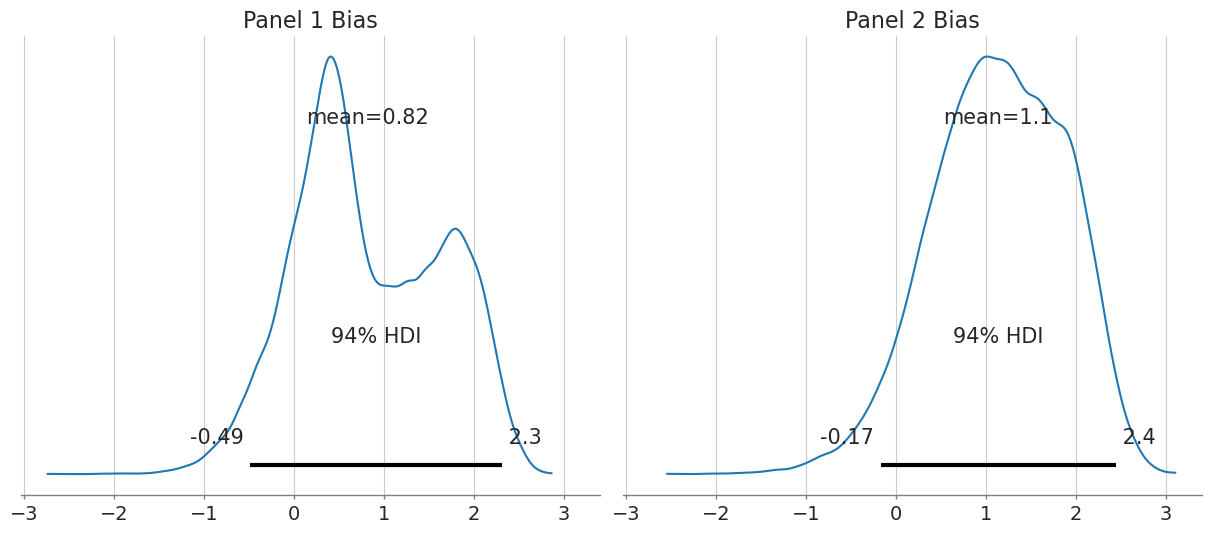

In [126]:
panel1 = np.concatenate([scores.columns[:5], scores.columns[10:15]]) 
panel2 = scores.columns[:-1].difference(panel1)
print(f"Panel 1 judges: {list(panel1)}")
print(f"Panel 2 judges: {list(panel2)}")

bias = az.extract(idata_7, var_names=['judge_bias'], keep_dataset=True)
bias_panel1 = bias.sel(judge=panel1)
bias_panel2 = bias.sel(judge=panel2)
bias_panel1

style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6*0.87), sharex=True)    
    axs=axs.flatten()
    az.plot_posterior(idata_7, var_names='judge_bias', coords={'judge':panel1}, combine_dims={'judge'}, ax=axs[0])
    az.plot_posterior(idata_7, var_names='judge_bias', coords={'judge':panel2}, combine_dims={'judge'}, ax=axs[1])
    axs[0].set_title('Panel 1 Bias')
    axs[1].set_title('Panel 2 Bias')

In [112]:
is_panel1A = bias_panel1.mean(dim='sample') < 0.82
panel1A = panel1[is_panel1A['judge_bias']]
panel1B = panel1[~is_panel1A['judge_bias']]
print(f"Panel 1A judges: {list(panel1A)}")
print(f"Panel 1B judges: {list(panel1B)}")


Panel 1A judges: ['Jimena Hoffner', 'Silvina Valz', 'Martin Ojeda', 'Laura Melo', 'Agustin Agnez', 'Roberto Zuccarino']
Panel 1B judges: ['Gaston Torelli', 'Magdalena Gutierrez', 'Lucas Paez', 'Analia Vega']


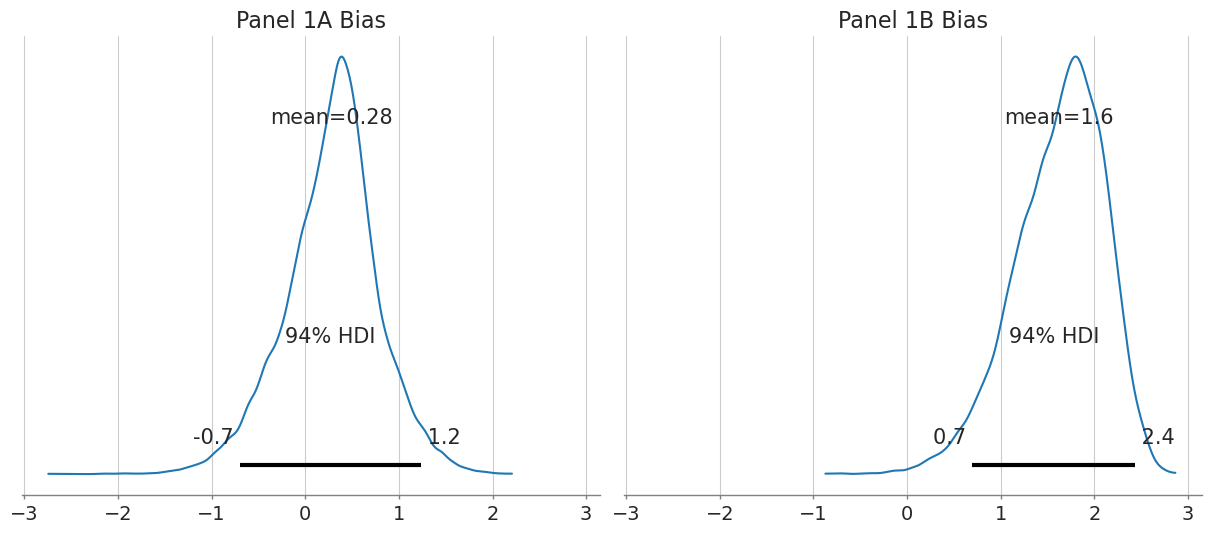

In [125]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6*0.87), sharex=True)    
    axs=axs.flatten()
    az.plot_posterior(idata_7, var_names='judge_bias', coords={'judge':panel1A}, combine_dims={'judge'}, ax=axs[0])
    az.plot_posterior(idata_7, var_names='judge_bias', coords={'judge':panel1B}, combine_dims={'judge'}, ax=axs[1])
    axs[0].set_title('Panel 1A Bias')
    axs[1].set_title('Panel 1B Bias')

The bias of the two panels is roughly the same and with HDI:s covering a similar range. However, it is very clear that Panel 1 is a mixed population with two subgroups. One group as a very low bias whereas the other has a very high bias. The population of Panel 1 is skewed towards a low bias which is a disadvantage of the couples being evaluated by this panel. 

### Is there a difference in the sensitivity between Panel 1 and Panel 2?

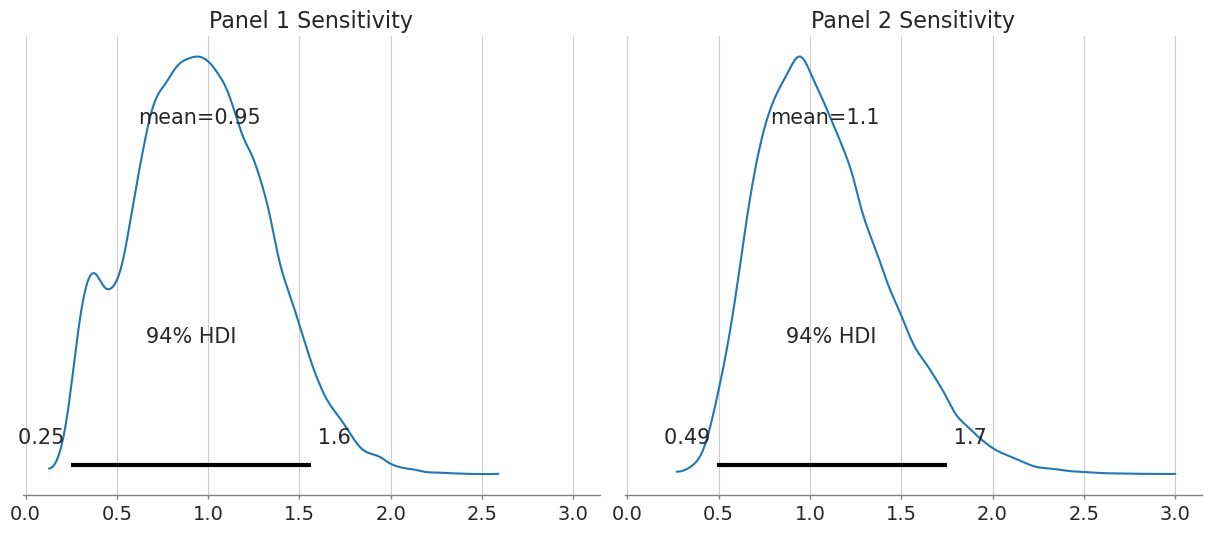

In [124]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6*0.87), sharex=True)    
    axs=axs.flatten()
    az.plot_posterior(idata_7, var_names='judge_sensitivity', coords={'judge':panel1}, combine_dims={'judge'}, ax=axs[0])
    az.plot_posterior(idata_7, var_names='judge_sensitivity', coords={'judge':panel2}, combine_dims={'judge'}, ax=axs[1])
    axs[0].set_title('Panel 1 Sensitivity')
    axs[1].set_title('Panel 2 Sensitivity')

The distributions of sensitivity almost completely overlap with very similar mean and HID:s. Hence there is no obvious difference between the panels regarding sensitivity, meaning that both panels can recognize the underlying ability of the couples. 

### Are couples evaluated by Panel 2 given higher scores than those evaluated by Panel 1?

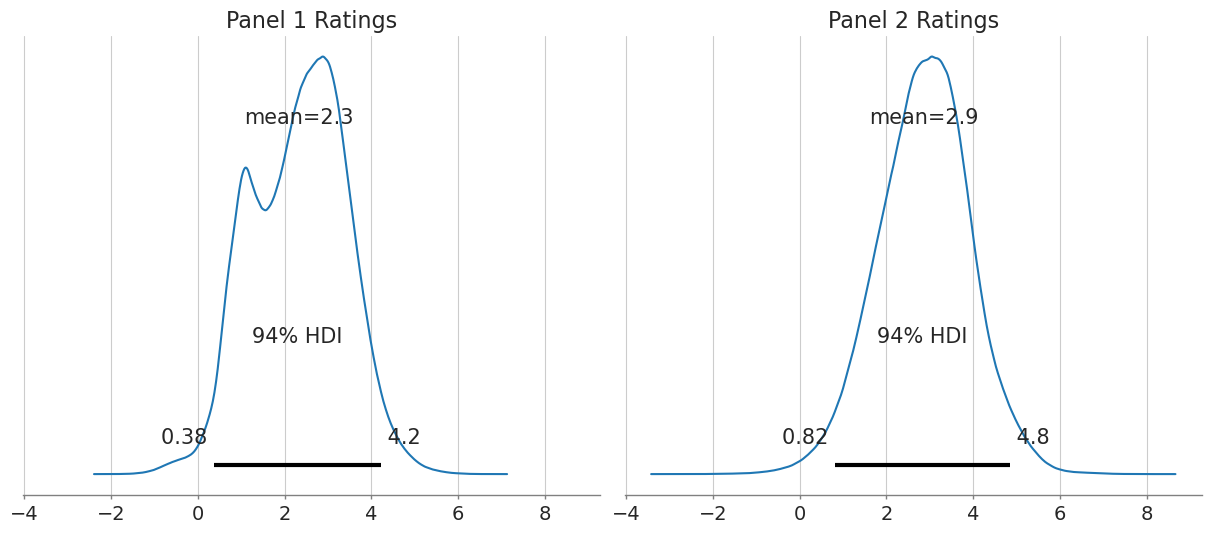

In [134]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6*0.87), sharex=True)    
    axs=axs.flatten()
    az.plot_posterior(idata_7, var_names='rating', coords={'obs_id':ordinal_scores.loc[ordinal_scores['judge'].isin(panel1)].index}, combine_dims={'obs_id'}, ax=axs[0])
    az.plot_posterior(idata_7, var_names='rating', coords={'obs_id':ordinal_scores.loc[ordinal_scores['judge'].isin(panel2)].index}, combine_dims={'obs_id'}, ax=axs[1])
    axs[0].set_title('Panel 1 Ratings')
    axs[1].set_title('Panel 2 Ratings')

This analysis clearly shows that the latent ratings of the couples (which are subsequently mapped to the ordinal scores), are slightly higher for Panel 2 than for Panel 1. The difference is however not significant as the HDI:s of the two distributions overlap.

### Is there a difference in the latent ability of the couples evaluated by Panel 1 and Panel 2, respectively?

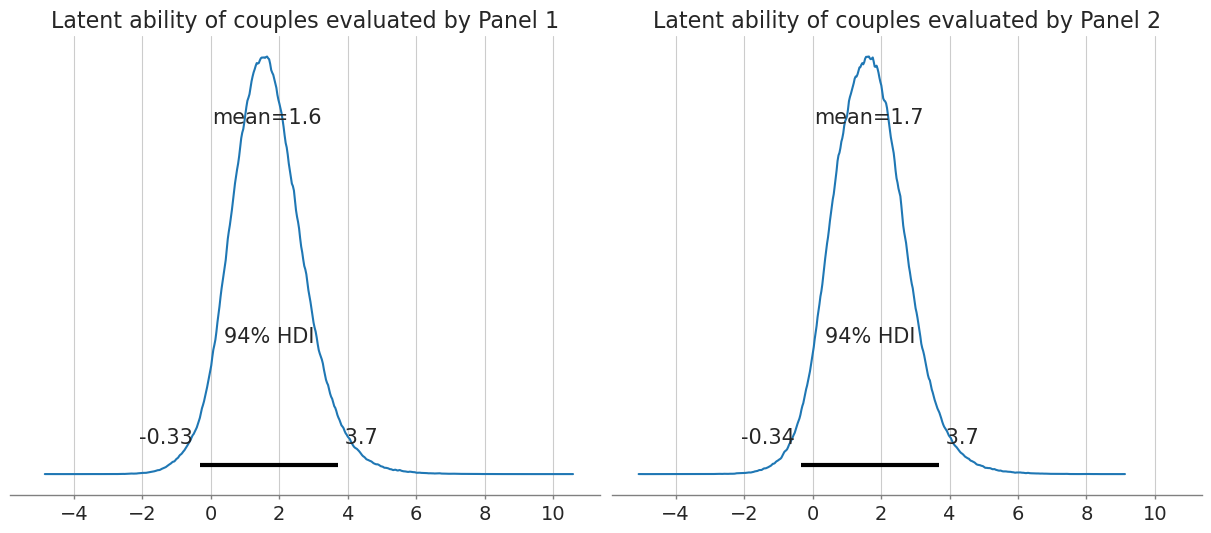

In [131]:
style = 'arviz-whitegrid'
with az.style.context(style, after_reset=True):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6*0.87), sharex=True)    
    axs=axs.flatten()
    az.plot_posterior(idata_7, var_names='mu_couple', coords={'couple':ordinal_scores.loc[ordinal_scores['judge'].isin(panel1), 'couple'].values}, combine_dims={'couple'}, ax=axs[0])
    az.plot_posterior(idata_7, var_names='mu_couple', coords={'couple':ordinal_scores.loc[ordinal_scores['judge'].isin(panel2), 'couple'].values}, combine_dims={'couple'}, ax=axs[1])
    axs[0].set_title('Latent ability of couples evaluated by Panel 1')
    axs[1].set_title('Latent ability of couples evaluated by Panel 2')

The distributions of the latent ability of the couples are close to identical. Hence, there is no difference in the latent ability of the couples which confirms that the couples evaluated by Panel 2 are given higher ratings due to the bias towards higher scores by these judges.

### Does the selection of couples who proceed to the semi-finals changes if we use the latent ability as the criterion?

In [141]:
min_score_for_semi_finals = 7.040
print(f"Number of couples that passed to the semi-finals: {scores.loc[scores['avg_score'] >= min_score_for_semi_finals].shape[0]}")
print(f"Fraction of couples that passed to the semi-finals: {scores.loc[scores['avg_score'] >= min_score_for_semi_finals].shape[0]/scores.shape[0]:.2f}")

Number of couples that passed to the semi-finals: 143
Fraction of couples that passed to the semi-finals: 0.28


In [178]:
avg_ability = az.extract(idata_7, var_names='mu_couple', keep_dataset=True).mean('sample').sortby(variables='mu_couple', ascending=False).to_dataframe().reset_index(drop=False)
avg_ability = avg_ability.merge(scores[['couple', 'avg_score', 'panel']], how='left', on='couple')
avg_ability['is_semi_finalist'] = avg_ability['avg_score'] >= min_score_for_semi_finals
print(f"Original semi_finalists in the top 143 couples: {np.sum(avg_ability['is_semi_finalist'][:143]==True)}")
print(f"New semi_finalists in the top 143 couples: {np.sum(avg_ability['is_semi_finalist'][:143]==False)}")
avg_ability[:143].loc[avg_ability['is_semi_finalist']==False]

Original semi_finalists in the top 143 couples: 117
New semi_finalists in the top 143 couples: 26


,couple,mu_couple,avg_score,panel,is_semi_finalist
46,46,2.767779,7.037,Panel 1,False
72,191,2.623381,7.010,Panel 1,False
74,540,2.616400,6.984,Panel 1,False
76,666,2.587879,6.947,Panel 1,False
80,434,2.550527,6.960,Panel 1,False
84,622,2.538380,7.001,Panel 1,False
86,384,2.491616,6.975,Panel 1,False
90,593,2.477051,6.994,Panel 1,False
91,432,2.475545,6.995,Panel 1,False
99,314,2.458815,7.035,Panel 1,False


Using the latent ability to select the top 143 couples includes 26 new couples that were not originally selected for the semi-finals. All of these couples were scored by the judges in Panel 1 which have been shown to have a bias towards lower scores. The latent ability should be a unbiased estimate and hence a better value to use for selecting the best couples.